In [ ]:
# This is included for documentation purpose, not a part of this tutorial
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

# Description of Motion

Consider a particle moving in 3D-Euclidean space as shown in the below image. Let's plot the diagram and animate the motion!

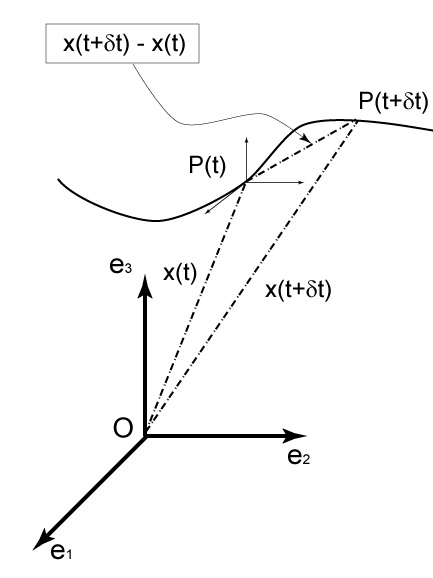

## Prerequisites

Import following libraries on your notebook

In [ ]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.spatial.distance import euclidean

In [ ]:
def create_line_trace(start, end, color='blue', width=2, name='', dash='solid', showlegend=False):
    line_trace = go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=width, dash=dash),
        name=name,
        showlegend=showlegend
    )
    return line_trace

def create_point_trace(point, color='red', size=5, name=''):
    x, y, z = point
    trace = go.Scatter3d(
        x=[x], y=[y], z=[z],
        mode='markers+text',
        marker=dict(color=color, size=size),
        text=[name],
        textposition="top center",
        showlegend=False
    )
    return trace

def create_arrow_trace(start, end, color='blue', name='', showlegend=False):
    # Create arrow shaft trace
    shaft_trace = go.Scatter3d(
        x=[start[0], end[0]], y=[start[1], end[1]], z=[start[2], end[2]],
        mode='lines',
        line=dict(color=color, width=5),
        name=name,
        showlegend=showlegend
    )

    # Create arrowhead trace
    vec = np.array(end) - np.array(start)
    length = np.linalg.norm(vec)
    vec_normalized = vec / length if length > 0 else vec
    arrowhead_size = 0.1 * length

    head_trace = go.Cone(
        x=[end[0]], y=[end[1]], z=[end[2]],
        u=[vec_normalized[0]], v=[vec_normalized[1]], w=[vec_normalized[2]],
        sizemode="absolute", sizeref=arrowhead_size, showscale=False,
        anchor="tip", colorscale=[[0, color], [1, color]]
    )

    return [shaft_trace, head_trace]

def create_3d_layout(title='3D Plot', gridcolor='lightblue', xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis'):
    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(showbackground=False, showgrid=True, zeroline=True, zerolinewidth=2, zerolinecolor='rgba(0,0,0,0.5)', showticklabels=True, gridcolor=gridcolor, title=xaxis_title),
            yaxis=dict(showbackground=False, showgrid=True, zeroline=True, zerolinewidth=2, zerolinecolor='rgba(0,0,0,0.5)', showticklabels=True, gridcolor=gridcolor, title=yaxis_title),
            zaxis=dict(showbackground=False, showgrid=True, zeroline=True, zerolinewidth=2, zerolinecolor='rgba(0,0,0,0.5)', showticklabels=True, gridcolor=gridcolor, title=zaxis_title),
        ),
        scene_aspectmode='cube'
    )
    return layout

def create_orthonormal_frame_traces(frame_name='e', origin=[0, 0, 0], length=1, color='blue', rotation_matrix=np.identity(3)):
    # Define standard basis vectors
    i = np.array([1, 0, 0])
    j = np.array([0, 1, 0])
    k = np.array([0, 0, 1])

    # Apply rotation
    i_rot = np.dot(rotation_matrix, i)
    j_rot = np.dot(rotation_matrix, j)
    k_rot = np.dot(rotation_matrix, k)

    # Create traces for rotated axes with arrows
    frame_traces = []
    frame_traces.extend(create_arrow_trace(start=origin, end=np.array(origin) + length * i_rot, color=color, name=f'{frame_name}_x'))
    frame_traces.extend(create_arrow_trace(start=origin, end=np.array(origin) + length * j_rot, color=color, name=f'{frame_name}_y'))
    frame_traces.extend(create_arrow_trace(start=origin, end=np.array(origin) + length * k_rot, color=color, name=f'{frame_name}_z'))

    return frame_traces

def animate_particle(curve_points, particle_name='Particle', particle_color='red', particle_size=6, animation_speed=10):
    # Creating frames for animation
    frames = []
    for i in range(0, len(curve_points), animation_speed):
        frame = go.Frame(data=[go.Scatter3d(
            x=[curve_points[i][0]],
            y=[curve_points[i][1]],
            z=[curve_points[i][2]],
            mode='markers+text',
            marker=dict(color=particle_color, size=particle_size),
            text=[particle_name],
            textposition='top center',
            textfont=dict(size=15)
        )])
        frames.append(frame)

    return frames

def create_particle_animation(curve_points, title='Particle Animation', name='P', origin=[0, 0, 0]):

    # Validate curve_points
    if not isinstance(curve_points, np.ndarray):
        raise ValueError("curve_points must be a NumPy array.")
    if curve_points.size == 0 or curve_points.ndim != 2 or curve_points.shape[1] != 3:
        raise ValueError("curve_points must be a non-empty 2D NumPy array with 3 columns (x, y, z coordinates).")

    traces = []
    frames = []

    x_vals, y_vals, z_vals = zip(*curve_points)

    # Add initial point and origin 'O'
    traces.append(create_point_trace(curve_points[0], color='green', size=8, name=name))
    traces.append(create_point_trace(origin, color='black', size=3, name='O'))

    # Set layout for the figure
    layout = create_3d_layout(title=title, xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis')

    # Add path trace
    traces.append(go.Scatter3d(
        x=x_vals, y=y_vals, z=z_vals,
        mode="lines",
        line=dict(color="blue", width=2),
        name='Path'
    ))

    # Animate the particle
    frames = animate_particle(curve_points, name, particle_color='green', particle_size=8, animation_speed=1)

    fig = go.Figure(data=traces, layout=layout, frames=frames)

    # Adjust the camera settings
    fig.update_layout(
        scene=dict(
            camera=dict(
                up=dict(x=0, y=0, z=1),  # Sets the up direction (in this case, the z-axis is up)
                center=dict(x=0, y=0, z=0),  # Centers the view on the given coordinates
                eye=dict(x=1, y=-1.25, z=1.25)  # Sets the position of the camera
            ),
            aspectmode='cube'  # Keeps the aspect ratio of the axes fixed
        )
    )

    # Add play and pause buttons
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(label="Play",
                          method="animate",
                          args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)]),
                    dict(label="Pause",
                          method="animate",
                          args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")])
                ]
            )
        ]
    )

    return fig

<div class="alert alert-info">

Note

The functions `create_line_trace`, `create_point_trace`, `create_arrow_trace`, and and others were written in previous tutorials. Please include them in your notebook on top before starting to follow this tutorial. You can download it by clicking the Download icon on the Navigation Bar.

</div>

## Steps

### Step 1: Define the Origin and End Points

Here, we define the coordinates of the origin ($O$), the starting point (start), and the ending point (end) for the motion of the particle.

In [ ]:
origin = [0, 0, 0]
start = [4, 1, 1]
end = [10, 10, 10]

### Step 2: Initialize an Empty List for Traces

An empty list is initialized to store Plotly traces.

In [ ]:
traces = []

### Step 3: Add a Random Curve and Get Curve Points


In [ ]:
def create_wavy_curve_traces(start_point, end_point, num_control_points=10, waviness=1,
                             color='blue', width=2, name='Wavy Curve', seed=None):

    # Generating control points
    control_points = np.linspace(np.array(start_point), np.array(end_point), num_control_points)
    random_offsets = waviness * np.random.rand(num_control_points, 3) - waviness / 2
    control_points += random_offsets
    control_points[0, :] = start_point
    control_points[-1, :] = end_point

    # Creating cubic spline through control points
    t = np.linspace(0, 1, num_control_points)
    spline_x = CubicSpline(t, control_points[:, 0])
    spline_y = CubicSpline(t, control_points[:, 1])
    spline_z = CubicSpline(t, control_points[:, 2])

    # Generating points along the spline
    t_fine = np.linspace(0, 1, 1000)
    curve_points_x = spline_x(t_fine)
    curve_points_y = spline_y(t_fine)
    curve_points_z = spline_z(t_fine)

    # Create traces
    line_trace = go.Scatter3d(x=curve_points_x, y=curve_points_y, z=curve_points_z,
                              mode='lines',
                              line=dict(color=color, width=width),
                              name=name)
    scatter_trace = go.Scatter3d(x=control_points[:, 0], y=control_points[:, 1], z=control_points[:, 2],
                                 mode='markers',
                                 marker=dict(color=color, size=width),
                                 name=f'{name} Control Points')

    curve_points = np.column_stack((curve_points_x, curve_points_y, curve_points_z))
    return [line_trace, scatter_trace], curve_points




In [ ]:
curve_traces, curve_points = create_wavy_curve_traces(start, end, seed=1, waviness=3, name=r'Path of the particle')

A wavy curve is created using the `create_wavy_curve_traces` function, and its traces and points are obtained.

### Step 4: Add Traces for Initial Particle Position and Curve

Traces for the initial position of the particle ($P$) and the curve are added to the list.

In [ ]:
traces.append(create_point_trace(point=curve_points[0], color='orange', size=5, name='P'))
traces.append(curve_traces[0])

### Step 5: Add Origin 'O'

A trace for the origin ($O$) is added to the list.

In [ ]:
traces.append(create_point_trace(origin, color='black', size=3, name='O'))

### Step 6: Create Orthonormal Frame Traces

Traces for the orthonormal frame ($e$) are created using the `create_orthonormal_frame_traces` function, and they are added to the list.

In [ ]:
frame_traces = create_orthonormal_frame_traces(frame_name='e', origin=origin, length=5, color='red')
traces.extend(frame_traces)

### Step 7: Select Points on the Curve

Points on the curve are selected based on a specified point distance.

In [ ]:
def select_points_on_curve(curve_points, point_distance=5):
    try:
        if not isinstance(curve_points, np.ndarray):
            raise TypeError("curve_points must be a numpy array.")
        if point_distance <= 0:
            raise ValueError("Point distance must be positive.")

        # Function to calculate arc length between two indices
        def calculate_arc_length(idx1, idx2):
            length = 0
            for i in range(idx1, idx2):
                length += euclidean(curve_points[i], curve_points[i + 1])
            return length

        # Finding two points approximately 'point_distance' apart
        idx1 = np.random.randint(0, len(curve_points) - 1)
        for idx2 in range(idx1 + 1, len(curve_points)):
            if calculate_arc_length(idx1, idx2) >= point_distance:
                return np.array([curve_points[idx1], curve_points[idx2]])

        raise ValueError("Unable to find two points with the specified distance apart on the curve.")

    except Exception as e:
        print(f"An error occurred: {e}")
        return np.array([])


In [ ]:
selected_points = select_points_on_curve(curve_points, point_distance=5)


### Step 8: Add Points on the Curve

Traces for the selected points on the curve are added to the list.

In [ ]:
traces.append(create_point_trace(point=selected_points[0], color='green', size=3, name='P(t)'))
traces.append(create_point_trace(point=selected_points[1], color='green', size=3, name='P(t+δt)'))

### Step 9: Add Lines Between Points

Traces for lines connecting points are added to represent motion and displacements.

In [ ]:
traces.append(create_line_trace(start=origin, end=selected_points[0], color='blue', width=3, dash='dash', name='x(t)', showlegend=True))
traces.append(create_line_trace(start=origin, end=selected_points[1], color='red', width=3, dash='dash', name='x(t+δt)', showlegend=True))
traces.append(create_line_trace(start=selected_points[0], end=selected_points[1], color='purple', width=3, dash='dash', name='x(t+δt) - x(t)', showlegend=True))

### Step 10: Add Orthonormal Frame at the First Selected Point

Traces for an orthonormal frame at the first selected point ($P$) are added.

In [ ]:
frame_traces_P = create_orthonormal_frame_traces(frame_name='P', origin=selected_points[0], length=2, color='black')
traces.extend(frame_traces_P)

### Step 11: Creating Frames for the Animation

Frames for animating the particle along the curve are created using the `animate_particle` function.

In [ ]:
frames = animate_particle(curve_points, 'P', particle_color='orange', particle_size=5, animation_speed=5)

### Step 12: Set Layout for the Figure

The layout for the figure is set using the `create_3d_layout` function, and the Plotly figure is created with traces and frames.

In [ ]:
layout = create_3d_layout(title='Point P in 3D Inertial Frame e', xaxis_title='e1 Axis', yaxis_title='e2 Axis', zaxis_title='e3 Axis')
fig = go.Figure(data=traces, layout=layout, frames=frames)

### Step 13: Adjust the Camera Settings and Update Layout

The camera settings are adjusted for better visualization.

In [ ]:
fig.update_layout(
    scene=dict(
        camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=1.25, y=-1.25, z=1.25)),
        aspectmode='cube'
    )
)

# Add Play and Pause Buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(label="Play",
                      method="animate",
                      args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)]),
                dict(label="Pause",
                      method="animate",
                      args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")])
            ]
        )
    ]
)

# Display the figure
fig.show()